In [1]:
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input

import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


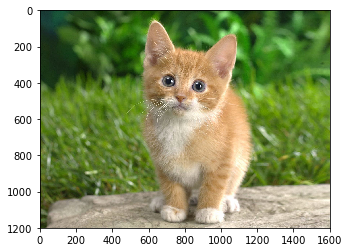

In [2]:
IMAGE_FILE = "/Users/tkmacl9/Desktop/cat_deep_dream.jpg"
img = plt.imread(IMAGE_FILE)
plt.imshow(img)

In [6]:
# preprocess and deprocess methods on the image 
def preprocess(img):
    img4d = img.copy()
    img4d = img4d.astype("float64")
    print(img4d.shape)
    if K.image_dim_ordering() == "th":
        # (H, W, C ) -> (C, H , W)
        img4d = img4d.transpose((2,0,1))
        print(img4d.shape)
    img4d = np.expand_dims(img4d, axis=0)
    print(img4d.shape)
    img4d = vgg16.preprocess_input(img4d)
    return img4d

def deprocess(img4d):
    img = img4d.copy()
    if K.image_dim_ordering == "th":
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
        img = img.transpose((1,2,0))
    else:
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
        img[:,:,0] += 103.939
        img[:,:,1] += 116.779
        img[:,:,2] += 123.68
        
        img = img[:,:,::-1]
        img = np.clip(img, 0, 255).astype("uint8")        
    return img

In [8]:
img_copy = img.copy()
print("Original shape of the image - ", img.shape)
p_img = preprocess(img_copy)
batch_shape = p_img.shape
print("new Shape - ", batch_shape)
dream = Input(batch_shape=batch_shape)
model = vgg16.VGG16(input_tensor=dream, weights="imagenet", include_top=False)

Original shape of the image -  (1200, 1600, 3)
(1200, 1600, 3)
(1, 1200, 1600, 3)
new Shape -  (1, 1200, 1600, 3)


In [9]:
layer_dict = {layer.name : layer for layer in model.layers}
print(layer_dict)

{'block4_conv3': <keras.layers.convolutional.Conv2D object at 0x12db55198>, 'block4_pool': <keras.layers.pooling.MaxPooling2D object at 0x12db6ef60>, 'input_3': <keras.engine.topology.InputLayer object at 0x13631e630>, 'block2_pool': <keras.layers.pooling.MaxPooling2D object at 0x1364a2da0>, 'block1_pool': <keras.layers.pooling.MaxPooling2D object at 0x136342b70>, 'block2_conv1': <keras.layers.convolutional.Conv2D object at 0x13a0f3160>, 'block3_conv2': <keras.layers.convolutional.Conv2D object at 0x1364c8da0>, 'block4_conv1': <keras.layers.convolutional.Conv2D object at 0x12581fe80>, 'block2_conv2': <keras.layers.convolutional.Conv2D object at 0x13a0fdf60>, 'block3_conv3': <keras.layers.convolutional.Conv2D object at 0x136394240>, 'block5_pool': <keras.layers.pooling.MaxPooling2D object at 0x12dd1e978>, 'block5_conv3': <keras.layers.convolutional.Conv2D object at 0x12dd02160>, 'block3_pool': <keras.layers.pooling.MaxPooling2D object at 0x1363b0a58>, 'block4_conv2': <keras.layers.convo

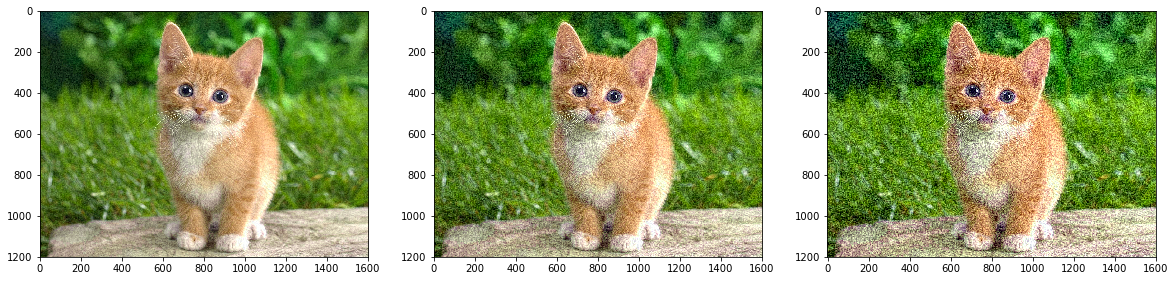

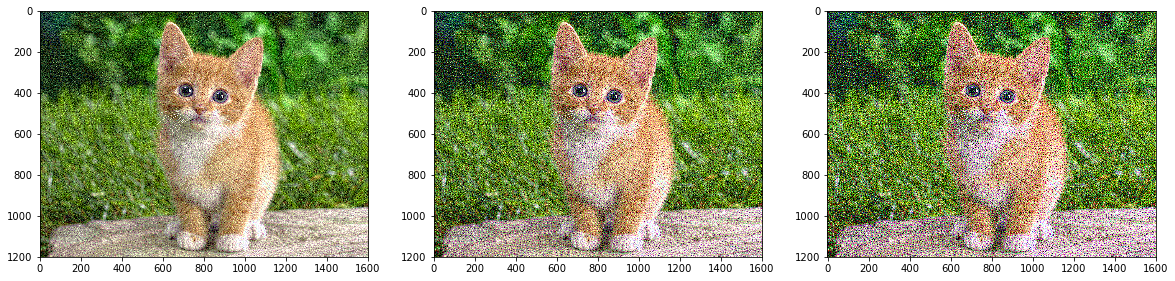

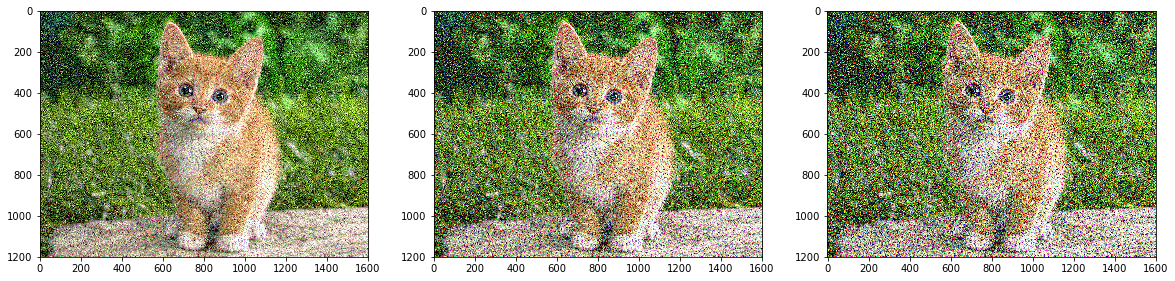

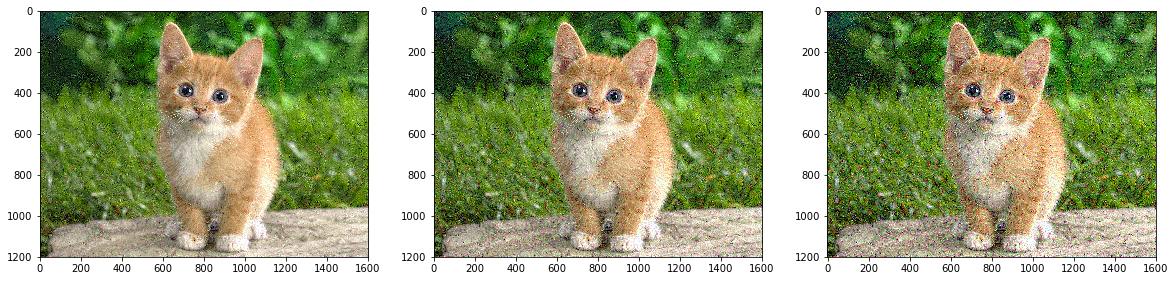

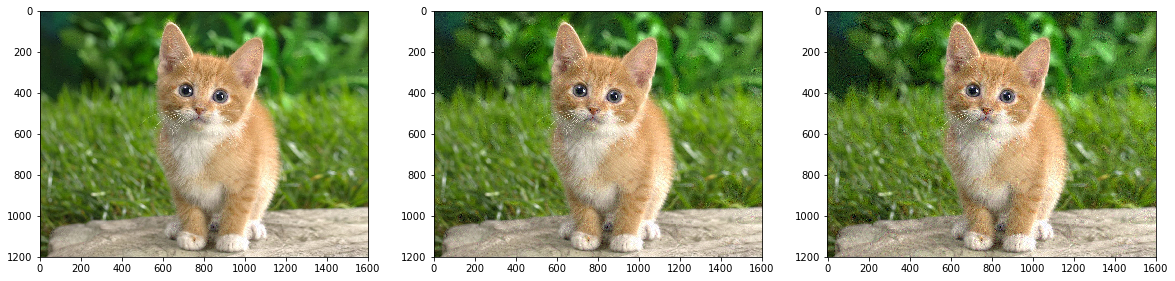

In [10]:
num_pool_layers = 5
num_iters_per_layer = 3
step = 100

for i in range(num_pool_layers):
    # identify each pooling layer
    layer_name = "block{:d}_pool".format(i+1)
    # build loss function that maximizes the mean activation in layer
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output)
    # compute gradient of image wrt loss and normalize
    grads = K.gradients(loss, dream)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # define function to return loss and grad given input image
    f = K.function([dream], [loss, grads])
    img_value = p_img.copy()
    fig, axes = plt.subplots(1, num_iters_per_layer, figsize=(20, 10))
    for it in range(num_iters_per_layer):
        loss_value, grads_value = f([img_value])
        img_value += grads_value * step 
        axes[it].imshow(deprocess(img_value))
    plt.show()